In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

<font size=6>
    Correlation study
</font>

In [113]:
def isHappy(n):
    """
    :type n: int
    :rtype: bool
    """

    func = lambda digits: sum(map(lambda x: x**2, digits))

    test = n
    happy = True
    saved = []
    while happy:

        digits = [int(d) for d in str(test)]
        test = func(digits)
        print(test)
        if test == 1:
            happy = False
            return True

        elif test in saved:
            return False
        else:
            saved.append(test)

In [116]:
isHappy(18)

65
61
37
58
89
145
42
20
4
16
37


False

<font color='black' size=5>
Summary
</font>

**Goal** drop the highly correlated features but keep a replacement which retains much of the information

**ToDo**

1. ~~Check the plots with the other methods~~
    * show that they drop too much $\to$ seem to drop right amount
        * what they keep is not as well-correlated with the targ as what they drop
2. New method replaces features with others which don't have above thresh. corr.
    * this happens indirectly: A -> B -> C but corr(A,C) < thresh.
    * **check** if this happens in real data
    * poss. soln.: keep track of who replaces who: 
        * if the replacer of a replacer has a lower correlation with the replacee
            * e.g. 
                1. corr(A,B) > thresh, corr(A,T) < corr(B,T) $\to$ replace A with B
                2. corr(B,C) > thresh, corr(B,T) < corr(C,T) $\to$ replace B with C
                3. implies C replaces A, but corr(A,C) < thresh $\to$ keep B
            
        
    
For each dropped col, 
1. check whether it's in the replacements for other cols
    * if so, don't drop
2. check it's replacements
    * drop the col with the lesser correlation with the target feature
    
Examples:
1. one col has one replacer
    * the col is not in the replacements set
    * the replacer only shows up once in the replacements set
    * get the column associated with min(col.corr(targ), replacer.corr(targ))


<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [3]:
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

# Data prep

## Create rand. correlation matrix

In [6]:
corr_matrix = np.abs(np.random.normal(loc=0.8,scale=0.24, size=[20,20])%1.05)

corr_matrix = np.clip(0,1, corr_matrix)
np.fill_diagonal(corr_matrix,1)
corr_matrix = (corr_matrix + corr_matrix.T)/2

cols = list(map(str, range(1,21)))
df_corr = pd.DataFrame(data=corr_matrix, index=cols, columns=cols)

In [7]:
# add some values to see what happens
df_corr.loc['1','5'] = 1.0
df_corr.loc['5','1'] = 1.0

### Get the correlations with the target variable

In [8]:
targ_corr = np.abs(np.random.normal(loc=0.4,scale=0.24, size=[20,1])%1.01)
np.clip(0,1, targ_corr);
#df_targ_corr = pd.DataFrame(data=targ_corr.T, index=['targ'], columns=cols)

In [9]:
df_corr.loc['targ',     :] = targ_corr.reshape(1,-1)
df_corr.loc[   :-1,'targ'] = targ_corr.reshape(1,-1)
df_corr.loc['targ','targ'] = 1.0

In [10]:
df_corr.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,targ
1,1.000000,0.771903,0.443250,0.841437,1.000000,0.757192,0.264758,0.413617,0.449674,1.015564,...,0.606636,0.403672,0.517755,0.577687,0.332189,0.768724,1.002443,0.622409,0.657391,0.258809
2,0.771903,1.000000,0.584402,0.921592,0.496246,0.882670,0.956020,0.740453,0.756988,0.603241,...,0.482245,0.639608,0.596513,0.471389,0.947422,0.413342,0.738745,0.778928,0.669935,0.895113
3,0.443250,0.584402,1.000000,0.541353,0.707891,0.570968,0.725360,0.626490,0.299993,0.688497,...,0.858838,0.078188,0.120635,0.964531,0.422826,0.631109,0.670422,0.529143,0.595843,0.694223
4,0.841437,0.921592,0.541353,1.000000,0.337890,0.813617,0.594927,0.895055,0.805670,0.594029,...,0.802232,0.437651,0.675937,0.343855,0.919045,0.558661,0.918082,0.926118,0.907533,0.314955
5,1.000000,0.496246,0.707891,0.337890,1.000000,0.760236,0.800168,0.886603,0.843250,0.801613,...,0.814567,0.579576,0.963986,0.538964,0.880245,0.813833,0.431148,0.561178,0.686070,0.415789


### Plots

In [11]:
threshold = 0.9

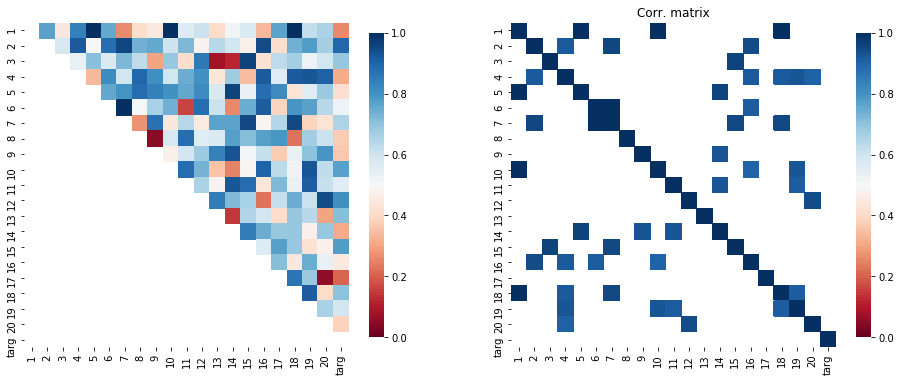

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax = ax.reshape(2)

df_upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
sns.heatmap(df_upper, cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[0]);

sns.heatmap(df_corr.where(df_corr > threshold), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);

plt.title(f'Corr. matrix');

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

# Drop features
## Get the corr. matrix into a skinny form with two cols and a value column

In [13]:
from helpers.correlation_feature_drop import get_correlation_pairs, get_dropped_columns_while, get_dropped_columns

In [97]:
test_list = ['11','19']
df_cpairs[
          ((df_cpairs['col1'].isin([test_list[0]])) &  \
            df_cpairs['col2'].isin([test_list[1]])) | \
          ((df_cpairs['col1'].isin([test_list[1]])) & \
            df_cpairs['col2'].isin([test_list[0]]))    
          ] 

,col1,col2,corr,self,targ
218,19,11,0.917396,True,0.561165
370,11,19,0.917396,True,0.595890


In [14]:
feature_drop = get_dropped_columns(df_corr, 'targ', 0.9, True)

Index(['col1', 'col2', 'corr'], dtype='object')
Index(['col1', 'col2', 'corr', 'self', 'targ'], dtype='object')
Incoming: 20
Retain: 17


,col1,col2,targ
0,1,"[1, 5, 10, 18]","[0.259, 0.416, 0.77, 0.704]"
1,10,"[1, 10, 16, 19]","[0.259, 0.77, 0.45, 0.596]"
2,11,"[11, 14, 19]","[0.561, 0.312, 0.596]"
3,12,"[12, 20]","[0.806, 0.386]"
4,14,"[5, 9, 11, 14]","[0.416, 0.364, 0.561, 0.312]"
5,15,"[3, 7, 15]","[0.694, 0.655, 0.777]"
6,16,"[2, 4, 6, 10, 16]","[0.895, 0.315, 0.528, 0.77, 0.45]"
7,18,"[1, 4, 7, 18, 19]","[0.259, 0.315, 0.655, 0.704, 0.596]"
8,19,"[4, 10, 11, 18, 19]","[0.315, 0.77, 0.561, 0.704, 0.596]"
9,2,"[2, 4, 7, 16]","[0.895, 0.315, 0.655, 0.45]"


Features: ['1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '14', '15', '16', '18', '19', '20']
Droppables: ['1', '3', '4', '6', '14', '16', '20']
Replacements: ['2', '5', '7', '9', '10', '11', '12', '15', '18', '19']
10 7
Incoming: 10
Retain: 7


,col1,col2,targ
0,10,"[10, 19]","[0.77, 0.596]"
1,11,"[11, 19]","[0.561, 0.596]"
2,15,"[7, 15]","[0.655, 0.777]"
3,18,"[7, 18, 19]","[0.655, 0.704, 0.596]"
4,19,"[10, 11, 18, 19]","[0.77, 0.561, 0.704, 0.596]"
5,2,"[2, 7]","[0.895, 0.655]"
6,7,"[2, 7, 15, 18]","[0.895, 0.655, 0.777, 0.704]"


Features: ['2', '7', '10', '11', '15', '18', '19']
Droppables: ['7', '11']
Replacements: ['2', '10', '15', '18', '19']
5 2
Incoming: 5
Retain: 3


,col1,col2,targ
0,10,"[10, 19]","[0.77, 0.596]"
1,18,"[18, 19]","[0.704, 0.596]"
2,19,"[10, 18, 19]","[0.77, 0.704, 0.596]"


Features: ['10', '18', '19']
Droppables: ['19']
Replacements: ['10', '18']
2 1
Incoming: 2
Retain: 0
0 0


## Plots

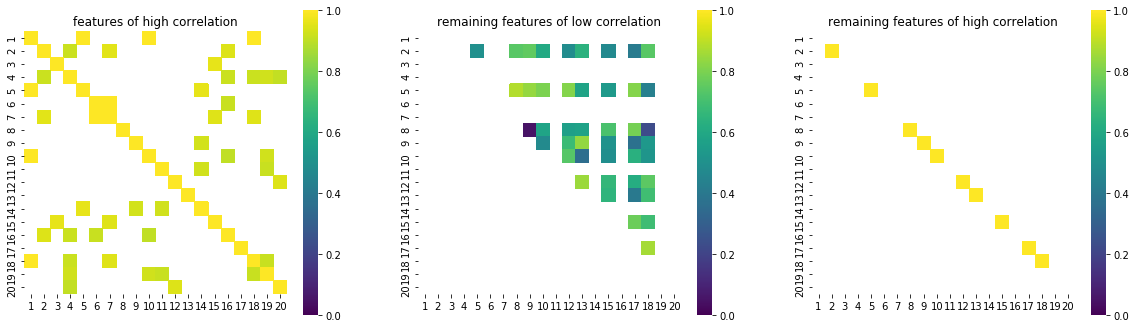

In [15]:
df_corr_na = df_corr.drop(index='targ', columns='targ').copy()

df_corr_na.loc[feature_drop,:] = np.NaN
df_corr_na.loc[:, feature_drop] = np.NaN


df_corr_cp = df_corr.drop(index='targ', columns='targ').copy()

df_upper = df_corr_na.where(np.triu(np.ones(df_corr_na.shape), k=1).astype(np.bool))

fig, ax = plt.subplots(1,3, figsize=(20,8))
ax = ax.reshape(3)

sns.heatmap(df_corr_cp.where(df_corr_cp > threshold), cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[0]);

ax[0].set_title(f'features of high correlation');

sns.heatmap(df_upper, cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);
#sns.heatmap(df_corr.where(df_corr > 0.9), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);
ax[1].set_title(f'remaining features of low correlation');

sns.heatmap(df_corr_na.where(df_corr_na > threshold), cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[2]);


ax[2].set_title(f'remaining features of high correlation');

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

## Check other methods

In [16]:
from helpers.correlation_feature_droppers import get_corr_feature_drop_1, get_corr_feature_drop_2, get_corr_feature_drop_3

In [17]:
df_corr_clean = df_corr.drop(index='targ', columns='targ').copy()

In [18]:
feature_drop_1 = get_corr_feature_drop_1(df_corr_clean, 0.90)

In [19]:
feature_drop_2 = get_corr_feature_drop_2(df_corr_clean, 0.90)

In [20]:
feature_drop_3 = get_corr_feature_drop_3(df_corr_clean, 0.90)

In [21]:
print(sorted(feature_drop, key=int))
print(sorted(feature_drop_1, key=int))
print(sorted(feature_drop_2, key=int))
print(sorted(feature_drop_3, key=int))

['1', '3', '4', '6', '7', '11', '14', '16', '19', '20']
['4', '5', '7', '10', '14', '15', '16', '18', '19', '20']
['4', '5', '7', '7', '10', '14', '14', '15', '16', '16', '18', '19', '20']
['4', '5', '7', '10', '14', '15', '16', '18', '19', '20']


In [22]:
df_meth_eval = pd.DataFrame(data=20*[1], index=df_corr.columns[:-1], columns=['full'])

In [23]:
df_meth_eval['drop'] =  1
df_meth_eval.loc[feature_drop, 'drop'] = 0
df_meth_eval['drop1'] =  1
df_meth_eval.loc[feature_drop_1, 'drop1'] = 0
df_meth_eval['drop2'] =  1
df_meth_eval.loc[feature_drop_2, 'drop2'] = 0
df_meth_eval['drop3'] =  1
df_meth_eval.loc[feature_drop_3, 'drop3'] = 0

In [24]:
df_meth_eval

,full,drop,drop1,drop2,drop3
1,1,0,1,1,1
2,1,1,1,1,1
3,1,0,1,1,1
4,1,0,0,0,0
5,1,1,0,0,0
6,1,0,1,1,1
7,1,0,0,0,0
8,1,1,1,1,1
9,1,1,1,1,1
10,1,1,0,0,0



**The problems:**
1. features are blindly dropped
* no chekcing to see if the droppable feature has better or worse correlation with the target feature
* no checking to see if the droppable feature is the replacement for another droppable feature (potentially dropping both features!)


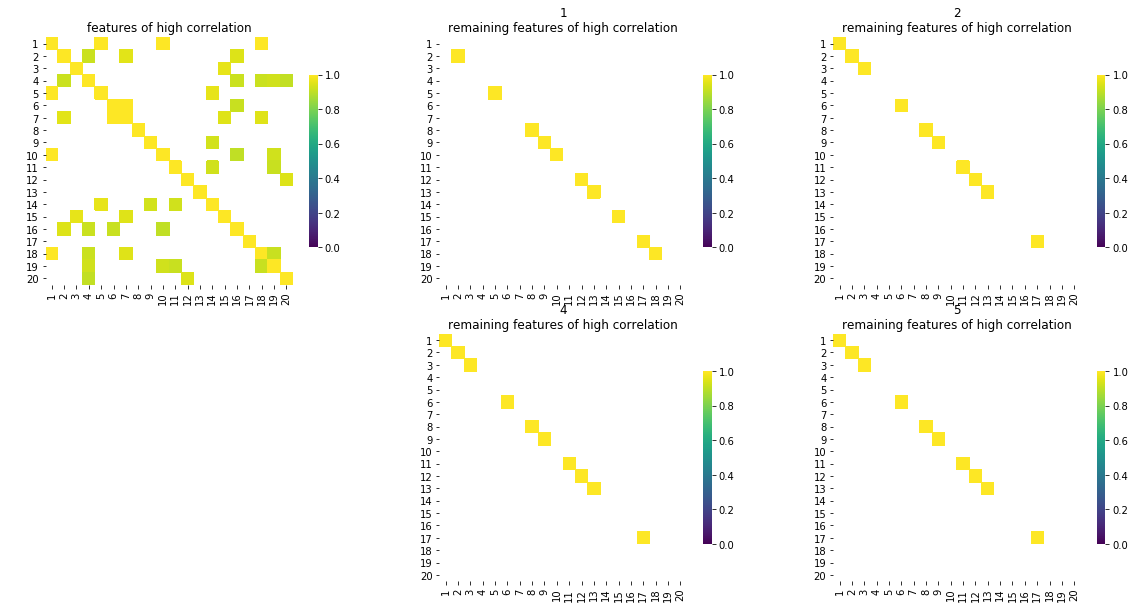

In [41]:


#df_corr_cp = df_corr.drop(index='targ', columns='targ').copy()

#df_upper = df_corr_na.where(np.triu(np.ones(df_corr_na.shape), k=1).astype(np.bool))

fig, ax = plt.subplots(2,3, figsize=(20,10))
ax = ax.reshape(6)

sns.heatmap(df_corr_cp.where(df_corr_cp > threshold), cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[0]);

ax[0].set_title(f'features of high correlation');

dropped_features_lists = [None, feature_drop, feature_drop_1, None, feature_drop_2, feature_drop_3]

for n in range(1,6):

    if n == 3: 
        ax[n].set_axis_off()
        continue
    
    d_f_l = dropped_features_lists[n]
    df_corr_na = df_corr.drop(index='targ', columns='targ').copy()

    df_corr_na.loc[d_f_l,:] = np.NaN
    df_corr_na.loc[:, d_f_l] = np.NaN
    
    #sns.heatmap(df_upper, cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[n]);
    #sns.heatmap(df_corr.where(df_corr > 0.9), cmap="RdBu", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[1]);
    
    sns.heatmap(df_corr_na.where(df_corr_na > threshold), cmap="viridis", vmin=0,  vmax=1., square=True, cbar_kws={"shrink": .7}, ax=ax[n]);
    ax[n].set_title(f'{n}\nremaining features of high correlation');


In [58]:
df_cpairs[(df_cpairs['col1'].isin(['10'])) & df_cpairs['col2'].isin(['1'])]

,col1,col2,corr,self,targ
9,10,1,1.015564,True,0.258809


In [49]:
keep_cols = [f for f in cols if f not in feature_drop]

In [55]:
df_cpairs[(df_cpairs['col1'].isin(keep_cols)) & \
          (df_cpairs['col2'].isin(keep_cols)) & \
          (df_cpairs['self']) & \
          (df_cpairs['corr']>0.9)]

,col1,col2,corr,self,targ


In [56]:
keep_cols = [f for f in cols if f not in feature_drop_1]

In [57]:
df_cpairs[(df_cpairs['col1'].isin(keep_cols)) & \
          (df_cpairs['col2'].isin(keep_cols)) & \
          (df_cpairs['self']) & \
          (df_cpairs['corr']>0.9)]

,col1,col2,corr,self,targ


In [35]:
ax[1]()

In [40]:
feature_drop.__name__()

AttributeError: 'list' object has no attribute '__name__'

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

## Walkthrough the functions

In [25]:
from helpers.correlation_feature_drop import get_correlation_pairs, get_dropped_columns_while

In [26]:
df_cpairs = get_correlation_pairs(df_corr, 'targ')

In [27]:
df_cpairs['self'] = True
df_cpairs.loc[df_cpairs['col1'] == df_cpairs['col2'],'self'] = False

### Join the target correlations to the corr. pairs

In [28]:
df_targ_corr = df_corr.loc[df_corr.columns[:-1],'targ'].reset_index().rename(columns={'index':'col2'})

In [29]:
df_targ_corr.head()

,col2,targ
0,1,0.258809
1,2,0.895113
2,3,0.694223
3,4,0.314955
4,5,0.415789


In [30]:
df_cpairs = df_cpairs.merge(df_targ_corr, on='col2', how='inner')

In [31]:
df_cpairs.head()

,col1,col2,corr,self,targ
0,1,1,1.000000,False,0.258809
1,2,1,0.771903,True,0.258809
2,3,1,0.443250,True,0.258809
3,4,1,0.841437,True,0.258809
4,5,1,1.000000,True,0.258809


### Filter, group, and select the replacer

1. For each feature, get the set of features which are highly correlated 
2. For each group of highly-correlated features, select the one with the highest correlation to the target as the replacer
3. Return the unique replacers as the features to keep

In [32]:
get_dropped_columns_while(df_cpairs, threshold, True)

Incoming: 20
Retain: 17


,col1,col2,targ
0,1,"[1, 5, 10, 18]","[0.259, 0.416, 0.77, 0.704]"
1,10,"[1, 10, 16, 19]","[0.259, 0.77, 0.45, 0.596]"
2,11,"[11, 14, 19]","[0.561, 0.312, 0.596]"
3,12,"[12, 20]","[0.806, 0.386]"
4,14,"[5, 9, 11, 14]","[0.416, 0.364, 0.561, 0.312]"
5,15,"[3, 7, 15]","[0.694, 0.655, 0.777]"
6,16,"[2, 4, 6, 10, 16]","[0.895, 0.315, 0.528, 0.77, 0.45]"
7,18,"[1, 4, 7, 18, 19]","[0.259, 0.315, 0.655, 0.704, 0.596]"
8,19,"[4, 10, 11, 18, 19]","[0.315, 0.77, 0.561, 0.704, 0.596]"
9,2,"[2, 4, 7, 16]","[0.895, 0.315, 0.655, 0.45]"


Features: ['1', '2', '3', '4', '5', '6', '7', '9', '10', '11', '12', '14', '15', '16', '18', '19', '20']
Droppables: ['1', '3', '4', '6', '14', '16', '20']
Replacements: ['2', '5', '7', '9', '10', '11', '12', '15', '18', '19']
10 7
Incoming: 10
Retain: 7


,col1,col2,targ
0,10,"[10, 19]","[0.77, 0.596]"
1,11,"[11, 19]","[0.561, 0.596]"
2,15,"[7, 15]","[0.655, 0.777]"
3,18,"[7, 18, 19]","[0.655, 0.704, 0.596]"
4,19,"[10, 11, 18, 19]","[0.77, 0.561, 0.704, 0.596]"
5,2,"[2, 7]","[0.895, 0.655]"
6,7,"[2, 7, 15, 18]","[0.895, 0.655, 0.777, 0.704]"


Features: ['2', '7', '10', '11', '15', '18', '19']
Droppables: ['7', '11']
Replacements: ['2', '10', '15', '18', '19']
5 2
Incoming: 5
Retain: 3


,col1,col2,targ
0,10,"[10, 19]","[0.77, 0.596]"
1,18,"[18, 19]","[0.704, 0.596]"
2,19,"[10, 18, 19]","[0.77, 0.704, 0.596]"


Features: ['10', '18', '19']
Droppables: ['19']
Replacements: ['10', '18']
2 1
Incoming: 2
Retain: 0
0 0


{'1', '11', '14', '16', '19', '20', '3', '4', '6', '7'}